##### Import the libraries

In [ ]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
import pandas as pd


##### Inputs

In [2]:
# Define the path to your image
file_name = "rectified_facade_DENW11AL0000h3Gt.jpg"

image_path = os.path.join("Evaluation_subset", file_name)

In [3]:
# Load the JSON file
file_path = os.path.join("Evaluation_subset", "labels_facade_dataset_2024-06-09-08-43-50.json")
with open(file_path, 'r') as f:
    data = json.load(f)

##### Facade area in meters

In [ ]:
# Load the Excel file
file_path = "soest_duesseldorf_combined_valid_results_with_geometry_with_width.xlsx"
df = pd.read_excel(file_path, dtype=str)  # Read as strings to avoid type issues

# Extract the gmlid from the filename
gmlid = file_name.replace("rectified_facade_", "").replace(".jpg", "")

# Search for the corresponding row
row = df[df["gmlid"] == gmlid]

if not row.empty:
    # Retrieve relevant facade height and width
    facade_height_meters = float(row["relevant_facade_height"].values[0])
    facade_width_meters = float(row["relevant_facade_width"].values[0])

    # Compute facade area
    facade_area = facade_height_meters * facade_width_meters

    rich.print(f"GMLID: {gmlid}")
    rich.print(f"Facade Height: {facade_height_meters} meters")
    rich.print(f"Facade Width: {facade_width_meters} meters")
    rich.print(f"Facade Area: {facade_area} square meters")
else:
    rich.print(f"No matching GMLID found for {gmlid}.")

GMLID: DENW11AL0000h3Gt

Facade Height: 9.081 meters

Facade Width: 11.26536719358218 meters

Facade Area: 102.30079948491978 square meters

##### image area in pixels

In [5]:
# Step 1: Find the image details for the given file name
image_details = next(item for item in data["images"] if item["file_name"] == file_name)

# Extract width and height
image_height_pixels = image_details["height"]
image_width_pixels = image_details["width"]

rich.print(f"Image Height: {image_height_pixels} pixels")
rich.print(f"Image Width: {image_width_pixels} pixels")

# Calculate the image area
image_area_pixels = image_height_pixels * image_width_pixels

# rich.print(f"Image dimensions for '{file_name}': {image_width}x{image_height}")
rich.print(f"Total image area for '{file_name}': {image_area_pixels} pixels²")

Image Height: 272 pixels

Image Width: 337 pixels

Total image area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 91664 pixels²

##### Ground truth area

In [6]:
image_id = next(item["id"] for item in data["images"] if item["file_name"] == file_name)

# Step 2: Filter annotations for the image_id and category "window" (category_id = 1)
window_annotations = [
    annotation for annotation in data["annotations"]
    if annotation["image_id"] == image_id and annotation["category_id"] == 1
]

# Step 3: Calculate total area and count
windows_area_gt = sum(ann["area"] for ann in window_annotations)
num_windows = len(window_annotations)

# rich.print(f"Number of windows: {num_windows}")
rich.print(f"Total window area for '{file_name}': {windows_area_gt} pixels²")

Total window area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 21784.693692249522 pixels²

##### Pixel size in square meters

In [7]:
# Calculate the pixel size in square meters
pixel_size_meters = (facade_width_meters / image_width_pixels) * (
        facade_height_meters / image_height_pixels)

rich.print("pixel size in meters", pixel_size_meters)

pixel size in meters 0.001116041188306421

##### load Faster RCNN

In [8]:
# Define the model
num_classes = 2  # Change this to the number of classes you have (including background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

In [ ]:
# Define the path to load the model
load_path = "fasterrcnn_checkpoint_2.pth"

# Load the checkpoint
checkpoint = torch.load(load_path)

# Load the model state dictionary
model.load_state_dict(checkpoint)

print(f"Model loaded from {load_path}")

Model loaded from fasterrcnn_checkpoint_2.pth


##### Calculate the predicted area

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)
# Define the path to your image
file_name = "rectified_facade_DENW11AL0000h3Gt.jpg"

image_path = os.path.join("Evaluation_subset", file_name)

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
with torch.no_grad():
    predictions = model(input_image)
    # rich.print("predictions", predictions)

# Extract predictions from the output
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']

# Filter boxes by scores > 0.5
threshold = 0.5
valid_boxes = boxes[scores > threshold]

# Get the count of valid boxes
num_valid_boxes = valid_boxes.shape[0]

# Calculate the area of each valid bounding box
areas = (valid_boxes[:, 2] - valid_boxes[:, 0]) * (valid_boxes[:, 3] - valid_boxes[:, 1])

# Sum the areas to get windows_area
windows_area_p = areas.sum().item()

# Print the total windows area
# rich.print(f"Number of valid boxes: {num_valid_boxes}")
rich.print(f"Total predicted windows area for '{file_name}': {windows_area_p} pixels²")


Total predicted windows area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 18918.984375 pixels²

##### WWR actual

In [12]:
facade_meters = image_area_pixels * pixel_size_meters

rich.print(f"facade in meters {facade_meters} meters²")

facade in meters 102.30079948491976 meters²

In [13]:
window_meters_GT = windows_area_gt * pixel_size_meters

rich.print(f"windows in meters ground trught {window_meters_GT} meters²")

windows in meters ground trught 24.31261543518955 meters²

In [14]:
window_meters_P = windows_area_p * pixel_size_meters

rich.print(f"windows in meters predcited {window_meters_P} meters²")

windows in meters predcited 21.11436580342561 meters²

In [15]:
WWR_GT_actual = window_meters_GT / facade_meters

rich.print(f"WWR Ground trugth {WWR_GT_actual}")

WWR Ground trugth 0.23765811760614333

In [16]:
WWR_p_actual = window_meters_P / facade_meters

rich.print(f"WWR predicted {WWR_p_actual}")

WWR predicted 0.20639492467053588

##### WWR

In [17]:
# Calculate ground truth WWR
wwr_gt = windows_area_gt / image_area_pixels if image_area_pixels > 0 else 0

rich.print(f"Window-to-Wall Ratio (ground truth) (WWR) for '{file_name}': {wwr_gt:.4f}")

# Calculate predicted WWR
wwr_P = windows_area_p / image_area_pixels if image_area_pixels > 0 else 0

rich.print(f"Window-to-Wall Ratio (predcited) (WWR) for '{file_name}': {wwr_P:.4f}")

# Calculate the absolute difference
wwr_difference = abs(wwr_gt - wwr_P)

# Optionally, calculate percentage difference
wwr_percentage_diff = (wwr_difference / wwr_gt * 100) if wwr_gt > 0 else 0

# Print the results
# rich.print(f"[bold]Difference between ground truth and predicted WWR:[/bold] {wwr_difference:.4f}")
# rich.print(f"[bold]Percentage difference:[/bold] {wwr_percentage_diff:.2f}%")

Window-to-Wall Ratio (ground truth) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.2377

Window-to-Wall Ratio (predcited) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.2064

##### Visualizing the results (Faster RCNN) on the Evalution subset

In [18]:
def visualize_predictions(predictions, image_tensor, threshold=0.5, class_names=None):
    """
    Visualizes predictions on an image.

    Args:
        predictions (dict): The predictions dictionary from Faster R-CNN, containing 'boxes', 'labels', and 'scores'.
        image_tensor (Tensor): The image tensor.
        threshold (float): Confidence threshold to filter boxes.
        class_names (list): List of class names, where index corresponds to class label (optional).
    """
    # Convert the tensor to a PIL image
    img = transforms.ToPILImage()(image_tensor.cpu())
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    # Draw each bounding box
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:  # Filter boxes by score
            x_min, y_min, x_max, y_max = box.detach().cpu().numpy()
            width, height = x_max - x_min, y_max - y_min

            # Draw the rectangle
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Get label name if provided, otherwise use label index
            label_text = class_names[label] if class_names else f"Class {label}"
            label_text = f"{label_text}: {score:.2f}"

            # Add label and score
            ax.text(x_min, y_min - 10, label_text, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

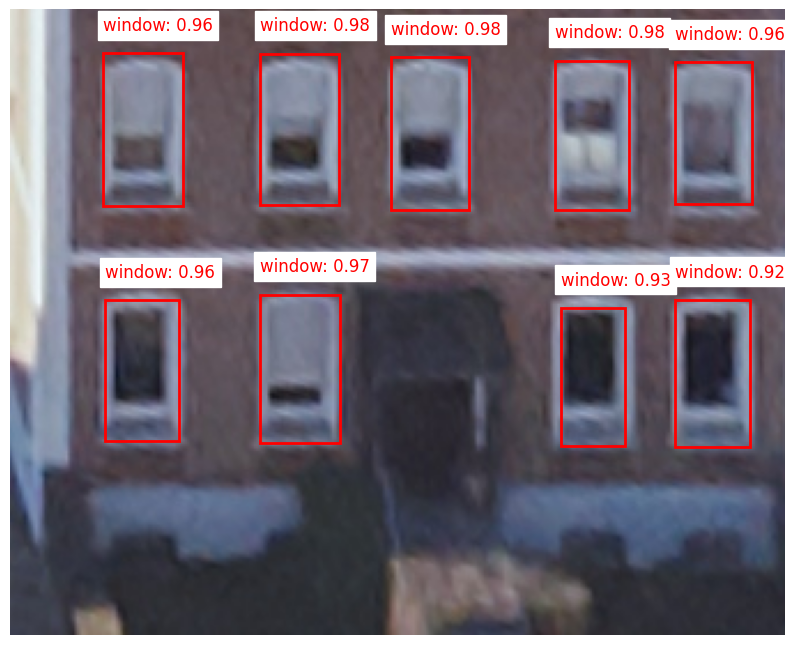

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)
# Define the path to your image
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
with torch.no_grad():
    predictions = model(input_image)
    # rich.print("predictions", predictions)

# Visualize the predictions
class_names = ["background", "window"]  # Adjust based on your class names
visualize_predictions(predictions[0], input_image[0], threshold=0.5, class_names=class_names)